**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage.measure import label, regionprops

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

### I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

Total vehicles: 8792, Total non-vehicles: 8968


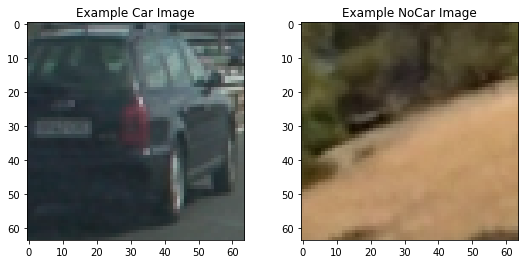

In [2]:
cars=glob.glob('dataset/vehicles/*/*.png')
notcars=glob.glob('dataset/non-vehicles/*/*.png')
print('Total vehicles: {}, Total non-vehicles: {}'.format(len(cars), len(notcars)))

ind = np.random.randint(0, len(cars))
# Read in the image
image_car = mpimg.imread(cars[ind])
image_nocar = mpimg.imread(notcars[ind])

fig = plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(image_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(image_nocar, cmap='gray')
plt.title('Example NoCar Image')

### Defined functions to compute binned color features, color histogram features and a function to extract these features form the images

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

### Some of these features are skewed to the left or right and most of the time a normalization of these features is needed:

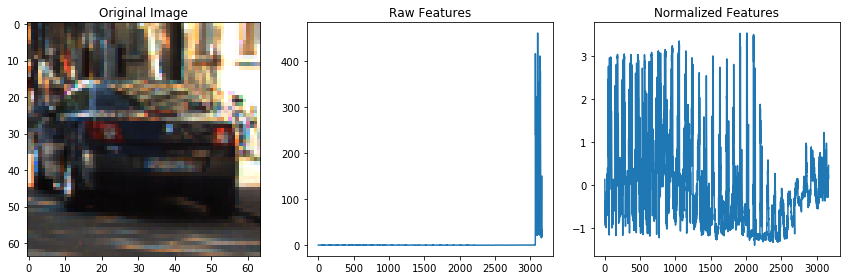

In [4]:
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### When trainning a LinearSVC model using only spatial feature the accuracy of the classifier of approx. 94%

In [5]:
spatial = 32
histbin = 32

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

('Using spatial binning of:', 32, 'and', 32, 'histogram bins')
('Feature vector length:', 3168)
(27.1, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9524)
('My SVC predicts: ', array([ 1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.]))
('For these', 10, 'labels: ', array([ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.]))
(0.01666, 'Seconds to predict', 10, 'labels with SVC')


### The accuracy of the model can be improved by adding additonal features such as Histogram of Gradients (HOG) 

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

### Here is an example using the `HLS` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


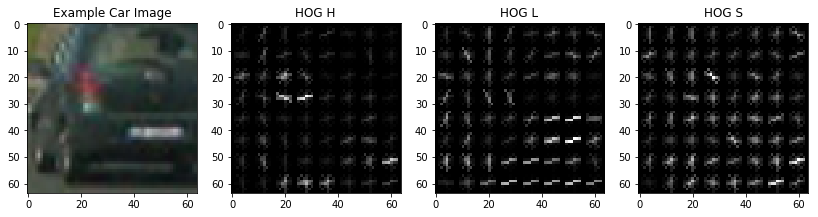

In [7]:
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])

#Test for different combinations of HOG parameters
#for orient in [6, 9, 10, 12]
#    for pix_per_cell in [4, 6, 8, 10, 12, 14, 16, 18, 20]:
#        for cell_per_block in [1, 2, 3, 4]:
#            img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#            features0, hog_image0 = get_hog_features(img_hls[:,:,0], orient, 
#                            pix_per_cell, cell_per_block, 
#                            vis=True, feature_vec=False)
#            features1, hog_image1 = get_hog_features(img_hls[:,:,1], orient, 
#                            pix_per_cell, cell_per_block, 
#                            vis=True, feature_vec=False)
#            features2, hog_image2 = get_hog_features(img_hls[:,:,2], orient, 
#                            pix_per_cell, cell_per_block, 
#                           vis=True, feature_vec=False)   


# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
features0, hog_image0 = get_hog_features(img_hls[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features1, hog_image1 = get_hog_features(img_hls[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features2, hog_image2 = get_hog_features(img_hls[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

fig = plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(142)
plt.imshow(hog_image0, cmap='gray')
plt.title('HOG H')
plt.subplot(143)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG L')
plt.subplot(144)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG S')

### It can be seen that with the usage of the additional features (e.g. HOG)  the accuracy of the classification model (in this case a linear SVM) is improving considerably:

In [8]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features_hog(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features_hog(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(133.74, 'Seconds to extract HOG features...')
('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 5292)
(65.06, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9789)
('My SVC predicts: ', array([ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.]))
('For these', 10, 'labels: ', array([ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.]))
(0.06624, 'Seconds to predict', 10, 'labels with SVC')


### Once the classifier was in place, with a pretty good detection/classification accuracy, I defined a function that return the hog features for a single image only. This has been used in tandem with a sliding window function that slides over an image and draws a bounding box around areas where the features learnt match the new ones. However the results are not reliable and a removal false positive mechanics needs to be added.

In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features_hog(img, color_space='HLS',orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='HLS', orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features_hog(test_img, color_space=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

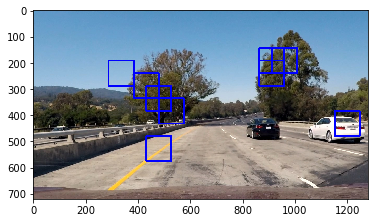

In [10]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

#print(image.shape)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,  
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

# Improvements

### Besides Linear SVM there are well know classifier that can outperform SVM. One of them is the Gradient Boosting Classifier

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

In [ ]:
# Confirm evaluation results
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

In [11]:
# Remember best params for further usage
HOG_ORIENT = 10
HOG_PPC = 16
HOG_CPB = 2
HOG_SIZE = 360
# load one sample image to get shape
sample_image = mpimg.imread(cars[0])
# This function takes dataset of images and returns dataset of features
def get_hog_data(X, colorspace, orient, pixpercell, cellperblock, featuresize):
    Xhog = np.zeros((X.shape[0], featuresize), dtype=np.float32)
    
    for idx in range(X.shape[0]):
        if colorspace == 'gray':
            x = cv2.cvtColor(X[idx], cv2.COLOR_RGB2GRAY)
        else:
            hls = cv2.cvtColor(X[idx], cv2.COLOR_RGB2HLS)
            x = hls[:,:,['h', 'l', 's'].index(colorspace)]
        
        f = get_hog_features(x, orient, pixpercell, cellperblock)
        Xhog[idx] = f
        
    return Xhog

In [13]:
sample_image.shape

(64, 64, 3)

In [14]:
# get all images data
X = np.zeros((len(cars) + len(notcars), 64,64,3), dtype=np.float32)
i = 0
for imgpath in cars:
    X[i] = mpimg.imread(imgpath)
    i += 1

for imgpath in notcars:
    X[i] = mpimg.imread(imgpath)
    i += 1
# generate label data
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars)))).astype(np.uint8)


In [15]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train = get_hog_data(X_TRAIN, 'l', HOG_ORIENT, HOG_PPC, HOG_CPB, HOG_SIZE)
X_scaler = StandardScaler().fit(X_train)

def preprocess_input(X):
    X = get_hog_data(X, 'l', HOG_ORIENT, HOG_PPC, HOG_CPB, HOG_SIZE)
    X = X_scaler.transform(X)
    return X

In [16]:
X_train = preprocess_input(X_TRAIN)
X_test =  preprocess_input(X_TEST)
clf = GradientBoostingClassifier()
clf.fit(X_train, Y_TRAIN)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [17]:
IMG_WIDTH = 1280
IMG_HEIGTH = 720
IMG_CENTER = 640
SLW_OVERLAP = .05
SLW_WINDOWS = [
    (96,  256),
    (150, 196),
    (200, 128),
    (230, 96),
]

In [18]:
def get_sliding_windows(img):
    windows = []
    images = []
    
    # For every defined sliding window
    for bottom_offset, window_size in SLW_WINDOWS:
        # Define step and total number of windows
        step = int(window_size * SLW_OVERLAP)
        total_windows = IMG_WIDTH // step + 1
        
        # For every single window
        for i in range(total_windows):
            # Define center and window width
            center = i * step
            deviation = float(center - IMG_CENTER) / IMG_CENTER
            window_width = int((window_size / 2) * (1. + deviation ** 2))
            
            # Calculate left and right X positions
            if center - window_width < 0:
                xleft = 0
                xrigh = center + window_width
            elif center + window_width > IMG_WIDTH:
                xleft = center - window_width
                xrigh = IMG_WIDTH
            else:
                xleft = center - window_width
                xrigh = center + window_width
                
            # Calculate Y positions
            yleft = IMG_HEIGTH - bottom_offset
            yrigh = yleft - window_size
            
            # Remember box coordinates and image patch
            windows.append([(xleft, yleft), (xrigh, yrigh)])
            images.append(img[yrigh:yleft, xleft:xrigh, :])
            
    return windows, images

In [19]:
# If image patch is not 64x64, resize it
def prepare_image_patch_for_classifier(img):
    if img.shape[0] != 64 or img.shape[1] != 64:
        img = cv2.resize(img, (64, 64))
    img = np.expand_dims(img, axis=0)
        
    return img

### Create the heatmap of the images and used windows of variable size

In [20]:
# Get heatmap of positive detections
def get_vehicles_heatmap_from_image(source_image, probability=.85):
    # Get all sliding windows and image patches
    windows, images = get_sliding_windows(source_image)
    
    # Define heatmap as zeros image
    heatmap = np.zeros((source_image.shape[0], source_image.shape[1]), dtype=np.uint8)
    
    i = 0
    for i in range(len(windows)):
        wnd, img = windows[i], images[i]
        
        # Preprocess image patch
        img = prepare_image_patch_for_classifier(img)
        img = preprocess_input(img)
        
        # Classify, but take not 0 or 1 class prediction, but raw probability
        clfproba = clf.predict_proba(img)[0]
        
        # Only if probability is high enouth, consider patch as vehicle and update heatmap
        if clfproba[1] > probability:
            xleft, yleft = wnd[0]
            xrigh, yrigh = wnd[1]
            heatmap[yrigh:yleft, xleft:xrigh] += 1

    return heatmap

In [21]:
# Take boundary boxes from a heatmap of positive detections
def get_boundaries_from_heatmap(heatmap):
    # If heatmap is empty, return empty boundaries
    if(heatmap.max() == 0):
        return []
    
    # Consider only heatmap valies greater than 1
    thresh = 1
    mask = np.zeros_like(heatmap)
    mask[heatmap > thresh] = 1
    
    # Use skimage.measure.label to label regions on the mask
    labeled = label(mask)
    boxes = []
    
    # Use skimage.measure.regionprops to get regois our of labelled image. Keep only images with big area
    for region in regionprops(labeled):
        if region.area < 5000:
            continue
        
        minr, minc, maxr, maxc = region.bbox
        boxes.append(((minc, minr), (maxc, maxr)))
    return boxes

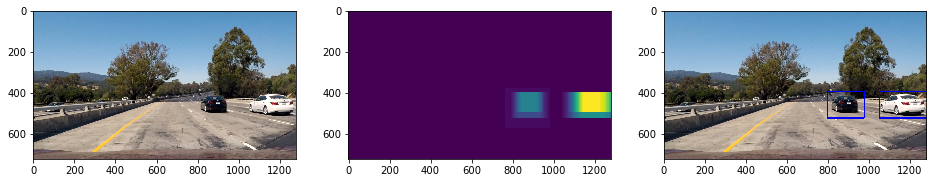

In [22]:
# Visualization
testimg = mpimg.imread('test_images/test1.jpg')
testimg_out = np.copy(testimg)
heatmap = get_vehicles_heatmap_from_image(testimg)
boxes = get_boundaries_from_heatmap(heatmap)
for box in boxes:
    p1, p2 = box
    cv2.rectangle(testimg_out, p1, p2, (0,0,255), 3)

_, axarr = plt.subplots(1, 3, figsize=(16,5))
axarr[0].imshow(testimg)
axarr[1].imshow(heatmap)
axarr[2].imshow(testimg_out)

### To get rid of false positives on the video I keep tracking centroid of detected boxes. I get boxes with sliding window for every found box calculate centroid

In [23]:
# Centroid class for easier handling of centroid information
class Centroid():
    
    CLOSENESS_DISTANCE = 50
    
    def __init__(self, coords=None):
        self.coords = coords
        
    def init_from_box(self, box):
        p1, p2 = box
        x = int((p1[0] + p2[0]) / 2)
        y = int((p1[1] + p2[1]) / 2)
        self.coords = (x, y)
        
    def get_distance_to_centroid(self, centroid):
        x1, y1 = self.coords
        x2, y2 = centroid.coords
        return np.sqrt((x1-x2)**2 + (y1-y2)**2)

    def is_close_to_centroid(self, centroid):
        return self.get_distance_to_centroid(centroid) < self.CLOSENESS_DISTANCE

In [24]:
# CentroidTracker is used to handle and store centroids data as well as tracker state itself
class CentroidTracker():
    
    # If 3 of 8 last frames have detections,last centroid is fine to draw
    DRAWABLE_SIZE = 8
    DRAWABLE_TRESHOLD = 3
    
    # If 5 of 15 last frames have detections and no new box found on this frame
    # it is ok to restore last box and use as current frame
    RESTORABLE_SIZE = 15
    RESTORABLE_TRESHOLD = 5
    
    # If last 10 frames have no detection, consider tracker as dead and remove
    DEATH_TOLERANCE = 10
    
    # Max number of history
    MAX_HISTORY = 15
    
    def __init__(self, centroid):
        self.centroids = [centroid]
        
        self.last_box = None
        self.detected = False
        self.detections = []
        
    # True if new centroid is close to last one of this tracker
    def check_new_centroid(self, centroid):
        if self.detected:
            return False
        
        last_centroid = self.centroids[-1]
        is_close_to_last = centroid.is_close_to_centroid(last_centroid)
        return is_close_to_last
    
    # Append new centroid if it matches current tracker
    def append_centroid(self, centroid):
        if self.check_new_centroid(centroid):
            self.centroids.append(centroid)
            self.detected = True
            return True
        return False
    
    # True if tracker has enough detections
    def is_last_centroid_drawable(self):
        n_last_detections = np.array(self.detections[-self.DRAWABLE_SIZE:]).sum()
        return n_last_detections >= self.DRAWABLE_TRESHOLD
    
    # True if tracker has enough detections in its lifetime
    def is_restorable(self):
        if len(self.detections) < self.RESTORABLE_SIZE:
            return False
        
        n_last_detections = np.array(self.detections[-self.RESTORABLE_SIZE:]).sum()
        return n_last_detections >= self.RESTORABLE_TRESHOLD
    
    # True if tracker has no detections for last DEATH_TOLERANCE frames
    def is_dead(self):
        # A young tracker is not yet dead
        if len(self.detections) < self.DEATH_TOLERANCE:
            return False
        
        last_steps = self.detections[-self.DEATH_TOLERANCE:]
        is_dead = not np.array(last_steps).any()
        return is_dead
    
    # Keep last detected box
    def set_last_box(self, box):
        self.last_box = box
    
    # Reset tracker detection state in the beginning of every frame
    def pre_frame_action(self):
        self.detected = False
    
    # Keep limited history
    def post_frame_action(self):
        self.detections.append(self.detected)
        self.detections = self.detections[-self.MAX_HISTORY:]
        self.centroids  = self.centroids[-self.MAX_HISTORY:]

In [25]:
# ImageProcessor for handling trackers and processing the image
class ImageProcessor():
    
    def __init__(self):
        self.trackers = []
        self.current_frame = None
        
    # Set current frame as a copy of incoming frame
    def set_frame(self, frame):
        self.current_frame = np.copy(frame)
        
    # Draw rectangle
    def draw_box_on_frame(self, box):
        p1, p2 = box
        cv2.rectangle(self.current_frame, p1, p2, (0,0,255), 3)
        
    # Calculate weighted rectangle to prevent big shape shaking
    def get_averaged_box(self, box1, box2):
        a1, a2 = box1
        b1, b2 = box2
        a1, a2, b1, b2 = np.array(a1), np.array(a2), np.array(b1), np.array(b2)
        
        avg1 = 0.9 * a1 + 0.1 * b1
        avg2 = 0.9 * a2 + 0.1 * b2
        
        result_box = ((int(avg1[0]), int(avg1[1])), (int(avg2[0]), int(avg2[1])))
        return result_box
        
    # Pre-frame trackers handler
    def pre_frame_action(self):
        for t in self.trackers:
            t.pre_frame_action()
        
    # Post-frame trackers handler
    def post_frame_action(self):
        alive_trackers = []
        for t in self.trackers:
            t.post_frame_action()
            
            # if tracker is dead (i.e. has no detectins), get rid of it
            if not t.is_dead():
                alive_trackers.append(t)
        self.trackers = alive_trackers
        
    # Main frame processing function
    def process_frame(self):
        # First, get boxes from current image
        heatmap = get_vehicles_heatmap_from_image(self.current_frame)
        boxes = get_boundaries_from_heatmap(heatmap)
        
        # reset tracker states before frame processing
        self.pre_frame_action()
        
        # check every found box
        for box in boxes:
            # get centroid
            c = Centroid()
            c.init_from_box(box)
            
            # by default, centroid is considered as a trash
            frame_box = None
            is_assigned = False
            is_drawable = False
            
            # try current centroid for every tracker to see which one it can match
            for tracker in self.trackers:
                # if matches, append to that tracker and check if it is drawable
                if tracker.check_new_centroid(c):
                    tracker.append_centroid(c)
                    
                    frame_box = box
                    if (tracker.last_box):
                        frame_box = self.get_averaged_box(tracker.last_box, frame_box)
                    tracker.set_last_box(frame_box)
                    
                    is_assigned = True
                    is_drawable = tracker.is_last_centroid_drawable()
                    break
                    
            # not matched to any tracker -- maybe a new car appeared on the road?
            if not is_assigned:
                newtracker = CentroidTracker(c)
                self.trackers.append(newtracker)
                
            if is_drawable:
                self.draw_box_on_frame(frame_box)
        
        # If no boxes found, check if any tracker is good enough to be restored
        if not len(boxes):
            for t in self.trackers:
                if t.is_restorable():
                    self.draw_box_on_frame(t.last_box)
                
        self.post_frame_action()
        return self.current_frame

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
IP = ImageProcessor()

def process_image(image):
    IP.set_frame(image)
    return IP.process_frame()

white_output = 'project_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|█████████▉| 1260/1261 [20:05<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 



## Discussion

  Although the accuracy of the detection was pretty high, testing it for videos shows that are still some challenges that need to be tacked. The most important part is getting rid of false positives and being able to track images at different scales. I think current pipeline can be further improved by introducing hard negative mining, and fine tuing of various parameters in the pipeline. Having said that, I think the deep learning end to end approach might have the potential to take this detection and tracking performance to a new level.